[View in Colaboratory](https://colab.research.google.com/github/kmanicka/CarND-Behavioral-Cloning-P3/blob/master/Model.ipynb)

# Udacity Car ND : Behavioral Cloning Project

This notebook is used to build and train the model used for driving the car autonomously 


## Versions 


#### Versions 9
- Version 9
    - Reduce 0 stearing data points
    - Train generator will have Random Transformations and generated "defined number of batches"
    - Validation Generator will generate all the validation samples in track 1
    - Result: loss: 0.0089 - val_loss: 0.0036, car able to cross the sand but got stuck in right turn. 

- Version 9A
    - remove left and right camera
    - batch size 128
    - epoc 25
- Version 9B
    - revert the left and right lane camera and made correction as a percentage rather than plane 0.2


#### Versions 8
- Data Augumentation do the reverse images, reverse 50% images in the batch. 
- Version 8 A
    - LeNet Arch conv32->conv64 -> dense32 -> dense8 no dropout, 40 epocs , 32 batch, 20 workers. 
    - loss: 0.0013 - val_loss: 0.0093.. high variance. need regularization
- Version 8 B
    - Test with smaller dense layers 
    - LeNet Arch conv32->conv64 -> dense16 -> dense4 no dropout (0.2), 40 epocs , 32 batch, 20 workers. 
    - Not COnverging
- Version 8 C
    - Same as 8A with Dropout (0.2) 
    - LeNet Arch conv32->conv64 -> dense32 -> dense8 WITH dropout (0.2), 40 epocs , 32 batch, 20 workers. 
    - Not COnverging
- Version 8D
    - Dropout 0.25 
    - regularized but failed to cross the sandbar in sumulation. 
- Version 8E
    - Dropout of 0.5 in 1st dense layer
    - The train and validation loss seem to converge. 
- Version 8F
    - remove the 2nd dense layer. 
    - The train and validation loss seem to converge to 0.0106/0.0105. 
- Version 8G
    - use keras.optimizers.Adadelta()
    - loss: 0.0086 - val_loss: 0.0083
    - testing in Demo, the car again crashed near the sand road area. 
    

#### Versions 7
- Try doing bulk read of images during Data Generator
- Exclude the left and right images
- Implement Validation Generator  (weights-7.hdf5)
- Shuffle is already being done by fit_generator, so remove functionality (weights-7A.hdf5)
- Trying the fit_generator parallel exectution to speed things up. (weights-7B.hdf5)

Results : 
- Bulk read of images significantly improved the speed of training.
- Doing shuffel on on_epoch_end improved training results. Note fit_geneator also shuffles at batch level.
- Using Parallel Execution reduced the training time per epoc to 10s without any impact on the model / training. 
- with weights version 7C we are able to cross the sand railing.


#### Versions 6
- Use Data Generator
- Data Augumentation : Left, Right and horizontally reveresed images. 
Result: Due to Data Generated logic training has become significantly slower. 
Did not see much improvement by Data Augumentation. 
instead the movement of car has be


#### Versions 5
- Merged build and train cells. 
- Merged Load and prepare data

#### Versions 4
- Normalization and croping in the Keras Layer
- Dropout in 3 layers 0.25
- Files changed the model and the drive.py 
Results : 
- Had a good run in the simulator. 

#### Versions 3
- Reduced the image height to concentrate on roads only.  
- the training and prediction image has changed. 

Result: The car drived well till it got distracted at road with brown road curb.  

#### Versions 2
A basic Lenet Model updated for linear regression. 


##  Workspace setup

* clean the workspace 
* download and unzip files
* list and assert files

```
date > log.txt
rm -rf *.zip  >> log.txt 2>&1
wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip >> log.txt 2>&1
unzip data.zip >> log.txt 2>&1
date >> log.txt 2>&1

ls
ls data
ls data/IMG | wc
```

### Data Generator 

In [65]:
# Reference https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html 

from skimage.io import imread
from  keras.utils import  Sequence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')



class TrainingDataGenerator(Sequence):

    def __init__(self,base_dir, batch_size, batches_per_epoch=1000,verbose=0) :
        
        self.verbose=verbose
        self.base_dir = base_dir
        self.batch_size = batch_size
        self.batches_per_epoch = batches_per_epoch

        # reduce the zero steering data 
        self.raw_data = pd.read_csv(self.base_dir + 'driving_log.csv', sep=',')
        
        self.__prepare_data__()

    def on_epoch_end(self):
        self.__prepare_data__()
    
    # called during init and end of epoch
    def __prepare_data__(self):
        train_nonzero = self.raw_data[self.raw_data.steering != 0]
        train_zero = self.raw_data[self.raw_data.steering == 0].sample(frac=.1)
        
        self.data = pd.concat([train_nonzero, train_zero], ignore_index=True)

        self.indexes = np.arange(len(self.data))
        np.random.shuffle(self.indexes)
        
        self.batches_in_dataset = int(len(self.data) / self.batch_size)
            
    
    def __len__(self):
        return self.batches_per_epoch

    def __getitem__(self, index_ignore):
        return self.__get_random_transformed_batch__()
    
    
    
    #get a random batch from the data set. 
    def __get_random_transformed_batch__(self, transformation=-1) :
        
        random_index = random.randint(0,self.batches_in_dataset-1)        
        low = random_index * self.batch_size
        top = low + self.batch_size
        
        indexes = self.indexes[low : top]
        
        if self.verbose == 1 :
            print(indexes)
        
        random_batch = self.data.iloc[indexes]
        
        transfomation = {0 : self.__transfomation_center,
                         1 : self.__transfomation_left,
                         2 : self.__transfomation_right,
                         3 : self.__transfomation_flip,
                         4 : self.__transfomation_left_flip,
                         5 : self.__transfomation_right_flip
        }

        #transfomation = {0 : self.__transfomation_center,                 
        #                 1 : self.__transfomation_flip
        #}

        
        #apply a random transfomation
        if transformation == -1 :
            transfomation_index = random.randint(0,len(transfomation)-1) 
        else :
            transfomation_index = transformation
        
        return transfomation[transfomation_index](random_batch) 
    
    def __transfomation_base(self,batch, camera_name='center', flip = False, steering_correction=1) :
        if self.verbose == 1 :
            print("__transfomation_base")
        
        filenames = batch[camera_name]
        
        X=None
        if flip == False :
            X = np.array([np.array(imread(self.base_dir + fname.strip())) for fname in filenames])
        else :
            X = np.array([np.flip(np.array(imread(self.base_dir + fname.strip())),1) for fname in filenames])
        
        y = batch["steering"] * steering_correction   
        
        return X,y.values 
        
    
    def __transfomation_center(self,batch) :
        return self.__transfomation_base(batch,'center',False,1)

    def __transfomation_left(self,batch) :
        return self.__transfomation_base(batch,'left',False,1.2)

    def __transfomation_right(self,batch) :
        return self.__transfomation_base(batch,'right',False,0.8)
        
    def __transfomation_flip(self,batch) :
        return self.__transfomation_base(batch,'center',True,-1)

    def __transfomation_left_flip(self,batch) :
        return self.__transfomation_base(batch,'left',True,-1.2)

    def __transfomation_right_flip(self,batch) :
        return self.__transfomation_base(batch,'right',True,-0.8)
    
    
class ValidationDataGenerator(Sequence):
    
    def __init__(self, base_dir, batch_size,verbose=0) :
        self.verbose = verbose
        self.base_dir = base_dir
        self.batch_size = batch_size
        self.data = pd.read_csv(self.base_dir + 'driving_log.csv', sep=',')
        
    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))
    
    def __getitem__(self, index):
        low = index * self.batch_size
        top = low + self.batch_size
        
        batch = self.data[low:top]
        
        filenames = batch["center"]
        X = np.array([np.array(imread(self.base_dir + fname.strip())) for fname in filenames])
        y = batch["steering"]
        
        return X,y.values
        

8036
4111
100
8036
1608
(5, 160, 320, 3)
(5,)
-0.0723724
0.047805752
-0.0
0.040210264


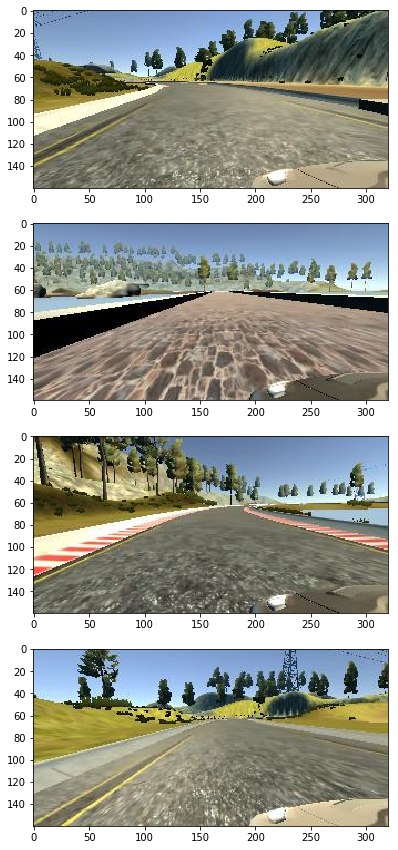

In [68]:
# Tests for the BehavioralDataGenerator 


train_generator = TrainingDataGenerator('data/', 5, 100,verbose=0)
validation_generator = ValidationDataGenerator('data/', 5)

print(len(train_generator.raw_data))
print(len(train_generator.data))
print(train_generator.__len__())

print(len(validation_generator.data))
print(validation_generator.__len__())

fig=plt.figure(figsize=(15, 15))
rows,columns = 4,1
i=0

#center image
X_batch, y_batch =train_generator.__get_random_transformed_batch__(5)

print(X_batch.shape)
print(y_batch.shape)

print(y_batch[0])
i=i+1
fig.add_subplot(rows, columns, i)
plt.imshow(X_batch[0])

print(y_batch[1])
i=i+1
fig.add_subplot(rows, columns, i)
plt.imshow(X_batch[1])

print(y_batch[2])
i=i+1
fig.add_subplot(rows, columns, i)
plt.imshow(X_batch[2])

print(y_batch[3])
i=i+1
fig.add_subplot(rows, columns, i)
plt.imshow(X_batch[3])



# Build and Train Model



In [69]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, Cropping2D,Lambda 
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta

height = 160
width = 320
channels = 3

def get_model(input_shape) :

    model = Sequential()
    
    #Layer Normilization
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
    
    #Layer Cropping
    model.add(Cropping2D(cropping=((44,20), (0,0))))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    #Layer Conv 1 
    model.add(Conv2D(32, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #Layer Conv 2
    model.add(Conv2D(64, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    
    #Layer Conv 3
    #model.add(Conv2D(24, (5, 5), padding="same"))
    #model.add(Activation("relu"))
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    #model.add(Dropout(0.25))

    #Layer Conv 4
    #model.add(Conv2D(48, (5, 5), padding="same"))
    #model.add(Activation("relu"))
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    #model.add(Dropout(0.25))
    
    #Layer Conv 5
    #model.add(Conv2D(96, (5, 5), padding="same"))
    #model.add(Activation("relu"))
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    #model.add(Dropout(0.25))
    
    model.add(Flatten())

    #Layer Dense 1
    model.add(Dense(32))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    #Layer Dense 2
    #model.add(Dense(8))
    #model.add(Activation("relu"))
    #model.add(Dropout(0.25))
    
    #Layer Dense 4
    model.add(Dense(1)) 

    model.compile(loss='mse', optimizer=Adadelta())


    return model

model = get_model((height,width,channels))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_5 (Cropping2D)    (None, 96, 320, 3)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 48, 160, 3)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 160, 32)       2432      
_________________________________________________________________
activation_13 (Activation)   (None, 48, 160, 32)       0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 24, 80, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 80, 64)        51264     
__________

Epoch 1/15
1000/1000 [==============================] - 76s 76ms/step - loss: 0.0284 - val_loss: 0.0095

Epoch 00001: saving model to work/weights-9B-01-0.0095.hdf5
Epoch 2/15
1000/1000 [==============================] - 75s 75ms/step - loss: 0.0173 - val_loss: 0.0094

Epoch 00002: saving model to work/weights-9B-02-0.0094.hdf5
Epoch 3/15
1000/1000 [==============================] - 68s 68ms/step - loss: 0.0154 - val_loss: 0.0085

Epoch 00003: saving model to work/weights-9B-03-0.0085.hdf5
Epoch 4/15
1000/1000 [==============================] - 75s 75ms/step - loss: 0.0135 - val_loss: 0.0077

Epoch 00004: saving model to work/weights-9B-04-0.0077.hdf5
Epoch 5/15
1000/1000 [==============================] - 74s 74ms/step - loss: 0.0134 - val_loss: 0.0069

Epoch 00005: saving model to work/weights-9B-05-0.0069.hdf5
Epoch 6/15
1000/1000 [==============================] - 74s 74ms/step - loss: 0.0121 - val_loss: 0.0068

Epoch 00006: saving model to work/weights-9B-06-0.0068.hdf5
Epoch 7/15

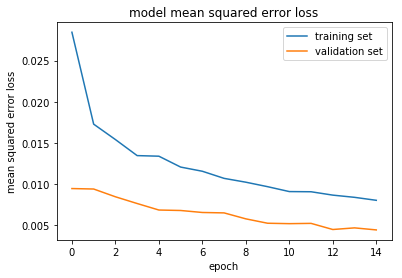

In [70]:
epochs=15
batches_per_epoch = 1000
batch_size = 64
workers=10

#weights_filepath="weights-7-{epoch:02d}-{val_loss:.2f}.hdf5"
weights_filepath="work/weights-9B-{epoch:02d}-{val_loss:.4f}.hdf5"


checkpoint = ModelCheckpoint(weights_filepath, verbose=1)

training_generator = TrainingDataGenerator('data/',batch_size=batch_size,batches_per_epoch=batches_per_epoch)
validation_generator = ValidationDataGenerator('data/',batch_size=batch_size)

history_object = model.fit_generator(generator=training_generator,
                                     validation_data=validation_generator,
                                     epochs=epochs,
                                     verbose=1,
                                     use_multiprocessing=True,
                                     workers=workers,
                                     callbacks=[checkpoint])

print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

